# Machine Learning - Project 2:
# _Unsteady parametrized Stokes equations in a 2D arterial bifurcation with stenosis: design of a LSTM Autoencoder for data compression_

## Context

In this notebook, we continue our study by focusing on __Long Short-Term Memory Autoencoder__ , or LSTM AE,using the same dataset generated on the first jupyter notebook `main.ipynb`.
Indeed, recurrent neural networks, such as LSTM, network are specifically designed to support sequences of input data. And since our simulations are time-dependent, it is interesting to use this specific model for our application.

Abbreviations used:
- $N_u$ = total number of spatial points per simulation
- $N_t$ = total number of time steps per simulation
- $N_s$ = total number of simulations

## Table of contents

[1. Data exploration](#data_exploration) 
- [Imports](#1imports)
- [Pathways](#1pathways)
- [Loading](#1load)
- [Exploration](#1exploration)

[2. Data preprocessing](#preprocessing)

[3. Pickle](#pickle)

[4. LSTM Autoencoder](#autoencoder)

[5. Discussions and conclusion](#ccl)

## 1. Data exploration  <a name="data_exploration"></a>

### Imports  <a name="1imports"></a>

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from helpers import *
from preprocessing import *
from sklearn.model_selection import train_test_split
from LSTM import *
from crossvalidation_lstm import *
import _pickle as cPickle
%load_ext autoreload
%autoreload 2
torch.manual_seed(0)
np.random.seed(1)
seed = 1

If you have already saved the pickle files, you can already jump [here](#start_pickle)!

### Pathways <a name="1pathways"></a>

In [7]:
DATA_PATH = 'data/'
DATA_Ux_PATH = DATA_PATH + 'u1_very_small.csv.bz2'
DATA_Uy_PATH = DATA_PATH + 'u2_very_small.csv.bz2'

### Loading <a name="1load"></a>

Let's load the data which consists of 2 matrices Ux, Uy denoting the x and y coordinates of the speed.

In [8]:
# Loading
Ux_pd = pd.read_csv(DATA_Ux_PATH, header=None)
Uy_pd = pd.read_csv(DATA_Uy_PATH, header=None)
# Converting from dataframe to numpy
Ux = Ux_pd.to_numpy()
Uy = Uy_pd.to_numpy()

### Exploration <a name="1exploration"></a>

Let's have a closer look at our imported data sets. The columns represent the time steps and the rows represent a point of our blood vessel mesh and each 5509 row a new simulation.

In [9]:
print("Our input array Ux is of shape:",Ux.shape)
print("Our input array Uy is of shape:",Uy.shape)
print("Printing a row of Ux:", '\n', Ux[10,:], '\n')
print("Printing a row of Uy:", '\n', Uy[10,:], '\n')

Our input array Ux is of shape: (137725, 110)
Our input array Uy is of shape: (137725, 110)
Printing a row of Ux: 
 [0.0694243  0.27537487 0.60389834 1.02538242 1.49979277 1.9813229
 2.42318455 2.78232553 3.02371067 3.12378595 3.22605803 3.32166836
 3.41249686 3.49946177 3.58301614 3.66339786 3.74073801 3.81511138
 3.88656184 3.95511576 4.02078945 4.08359325 4.14353388 4.20061589
 4.2548424  4.30621561 4.35473712 4.40040807 4.44322934 4.48320158
 4.52032526 4.55460075 4.58602833 4.61460821 4.64034055 4.66322547
 4.68326307 4.70045341 4.71479655 4.72629252 4.73494137 4.7407431
 4.74369775 4.74423086 4.74375285 4.74246986 4.74042825 4.73764939
 4.73414407 4.72991811 4.7249748  4.71931611 4.71294324 4.70585693
 4.6980577  4.68954587 4.68032167 4.67038525 4.65973675 4.64837623
 4.63630377 4.6235194  4.61002317 4.5958151  4.5808952  4.5652635
 4.54892001 4.53186473 4.51409767 4.49561883 4.47642823 4.45652585
 4.43591171 4.41458581 4.39254814 4.36979872 4.34633752 4.32216457
 4.29727986 4.27

For the rest of the analysis, we need to figure out the number of simulation step. As we know that we previsouly generated 25 simulations on Matlab and all the new simulations are appended row-wise, we can deduce it with the following computation.

In [10]:
positions =5509 #We know it from the matlab code
times = Ux.shape[1]
simulations = int(Ux.shape[0]/positions)
print("We ran ", simulations, "simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)")
print("1 simulation calculate the velocities of the blood flow at", positions, "different positions and at", times, "different times")

We ran  25 simulations with different parameters for each simulation (parameters of the stenosis and resistance of the blood flow in the bifurcations)
1 simulation calculate the velocities of the blood flow at 5509 different positions and at 110 different times


## 2. Data preprocessing  <a name="preprocessing"></a>

Let's check if we have any NaN or None values in our dataframe.

In [11]:
print(np.count_nonzero(np.isnan(Ux)))
print(np.count_nonzero(np.isnan(Uy)))

0
0


It seems there are __no None or NaN values__ so we can start direclty preprocess our datasets.

Let's sample our data points into the following ratios. 

In [12]:
ratio_pts = 0.01
ratio_time = 1

new_Ux, new_Uy, new_inds = sample(Ux, Uy, ratio_pts, ratio_time)
print(new_Ux.shape, new_Uy.shape)

(1375, 110) (1375, 110)


In [13]:
new_Nu, new_Nt = get_Nu_Nt_sampled(Ux, new_Ux)

print('With the sampling we got from', 5509, 'positions to', new_Nu, 'positions')
print('With the sampling we got from', 110, 'time steps to', new_Nt, 'time steps')

With the sampling we got from 5509 positions to 55 positions
With the sampling we got from 110 time steps to 110 time steps


We can look at the positions of the sampled positions to make sure that we cover mostly all the important parts of the geometry of the artery.

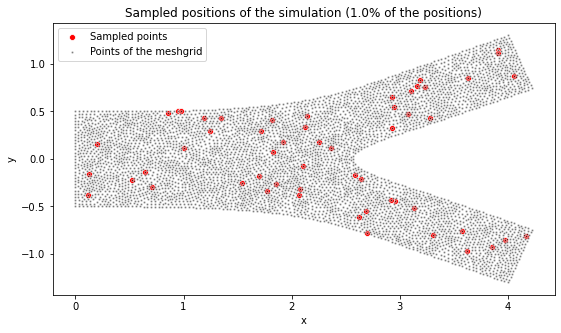

In [14]:
plot_sampled_coord(new_inds) 

Let's flatten our matrices into a 2D matrices with dimensions $(N_s, (2 N_u),  N_t)$. For each simulation, the x and y speed coordinates are compressed to the following 2D matrix:



$$
\mathbf{M_{2D}}
=
\begin{bmatrix}
\vdots & \vdots & \vdots & \vdots \\
u_{x}^{(0)} & u_{x}^{(1)} & \cdots &
u_{x}^{(N_t - 1)} \\
\vdots & \vdots & \ddots & \vdots \\
u_{y}^{(0)} & u_{y}^{(1)} & \cdots &
u_{y}^{(N_t - 1)} \\
\vdots & \vdots & \vdots & \vdots
\end{bmatrix}
$$

In [15]:
flattened_array = flatten_2d(new_Ux, new_Uy, ratio_pts)
flattened_array.shape

(25, 110, 110)

Let's make a sanity check that the dimension of 1 datapoint is indeed $({2 * new_{N_t}, new_{N_u})}$.

In [16]:
assert flattened_array.shape[1] == 2*new_Nu
assert flattened_array.shape[2] == new_Nt

## 3. Pickle  <a name="pickle"></a>

To avoid the loading and processing steps each time we open the notebook, we will save the processed matrix "flattened_array" using pickle. 

In the following cell, we will create pickles for every subsampled data according to the ratios_pts and the ratios_t.

In [17]:
ratios_pts = [0.1, 0.05, 0.02]
ratios_t = [0.5, 0.25, 0.1]

create_subsamples(Ux, Uy, ratios_pts, ratios_t, name_file='lstm_very_small', lstm=True)

The cell above is only intented to be run __once__.

#### Start from here if you the pickle file already exist in your data folder <a name="start_pickle"></a>

Change only the following cell to change the name of the file you want to open.

In [46]:
ratios = [0.1, 0.5]
size = ['lstm_very_small', 'lstm_middle_small', 'lstm_small']

name = 'processed_'+str(size[0])+'_'+str(ratios[0])+'_'+str(ratios[1])

print('name of the file you want to read : ', name)

name of the file you want to read :  processed_lstm_very_small_0.1_0.5


In [47]:
flattened_array = cPickle.load(open("data/pickle/"+str(size[0])+"/"+name, "rb"))

In [48]:
print(flattened_array.shape)

(25, 1100, 55)


##### Final step : split train/test

We split the data set into a training a testing set to be able to evaluate our autoencoder.

In [49]:
from sklearn.preprocessing import MinMaxScaler

for i in range(flattened_array.shape[0]):
    scaler = MinMaxScaler()
    scaler.fit(flattened_array[i])
    flattened_array[i] = scaler.transform(flattened_array[i])

In [50]:
x_train, x_test = train_test_split(flattened_array, test_size=0.1, random_state=seed)
y_train, y_test = x_train, x_test

print(x_train.shape)
print(x_test.shape)

(22, 1100, 55)
(3, 1100, 55)


## 4. LSTM Auto-encoder  <a name="autoencoder"></a>

In [2]:
input_dim = 55
seq_len = 1100
hidden_size = 5
model = LSTMAE(input_dim, hidden_size)

#### Parameters tuning

Find the best learning rate and momentums of our model using cross-validation :

In [54]:
# define network parameters
learning_rates = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5] 
momentums = [0.1, 0.5, 0.7, 0.9, 0.99]
epochs= 50
input_size=x_train.shape[2]
k_folds = 5
dataset_name = "middle_small" #Only used to save the plot with the good name
hidden_size = 5

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

In [55]:
results, best_result, best_lr, best_mom = tuning_lr_momentum_lstm(x_train, k_folds, input_size, epochs, criterion, learning_rates, hidden_size, momentums, dataset_name_=dataset_name, plot=True)

Momentum =  0.1

Learning rate =  0.1

Performance of 5 fold cross validation: 
Average Training Error: 0.661 	 Average Test Error: 0.663
 
Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 0.970 	 Average Test Error: 0.972
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 1.009 	 Average Test Error: 1.011
 
Learning rate =  0.0001

Performance of 5 fold cross validation: 
Average Training Error: 1.013 	 Average Test Error: 1.015
 
Learning rate =  1e-05

Performance of 5 fold cross validation: 
Average Training Error: 1.014 	 Average Test Error: 1.016
 
Momentum =  0.5

Learning rate =  0.1

Performance of 5 fold cross validation: 
Average Training Error: 0.469 	 Average Test Error: 0.470
 
Learning rate =  0.01

Performance of 5 fold cross validation: 
Average Training Error: 0.938 	 Average Test Error: 0.940
 
Learning rate =  0.001

Performance of 5 fold cross validation: 
Average Training Error: 1.006 	

,m=0.1,m=0.5,m=0.7,m=0.9,m=0.99
lr=0.1,0.663107,0.972272,1.011258,1.015290,1.015695
lr=0.01,0.470164,0.940059,1.007766,1.014938,1.015660
lr=0.001,0.323379,0.895272,1.002680,1.014422,1.015608
lr=0.0001,0.287671,0.717415,0.979820,1.012062,1.015371
lr=1e-05,0.287100,0.320092,0.877256,1.000781,1.014232



Best learning rate is 0.1  with a best momentum of 0.99 with a best error of:  0.28710038551609923



Find the best number of neurons in the latent space (neurons in the "middle layer of the auto-encoder") in the auto-encoder (which is actually the dimension of the compressed data) : 

In [59]:
# define network parameters
lr = best_lr # from above
momentum = best_mom # from above
epochs= 50
input_size=x_train.shape[2]
k_folds = 5
hidden_sizes = [3, 5, 6, 8, 10]
dataset_name = "middle_small" #Only used to save the plot with the good name

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss()  

Number of neurons =  3

Performance of 5 fold cross validation: 
Average Training Error: 0.284 	 Average Test Error: 0.286
 
Number of neurons =  5

Performance of 5 fold cross validation: 
Average Training Error: 0.284 	 Average Test Error: 0.287
 
Number of neurons =  6

Performance of 5 fold cross validation: 
Average Training Error: 0.284 	 Average Test Error: 0.287
 
Number of neurons =  8

Performance of 5 fold cross validation: 
Average Training Error: 0.284 	 Average Test Error: 0.286
 
Number of neurons =  10

Performance of 5 fold cross validation: 
Average Training Error: 0.283 	 Average Test Error: 0.286
 
The results obtained for the number of latent neurons tested are the following: [0.2858772630990777, 0.28710038551609923, 0.28650951630847404, 0.2864358930803411, 0.2864113329901822].
The best average test error obtained is 0.2858772630990777, and it is obtained with 3 neurons in the latent layer.


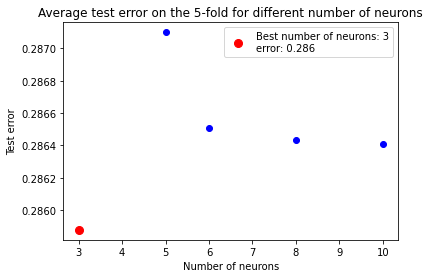

In [60]:
best_result, best_neurons_nb = tuning_latent_layer_lstm(x_train, k_folds, input_size, epochs, criterion, lr, hidden_sizes, momentum,dataset_name_=dataset_name)

#### Let's try with the tuned parameters and see how it goes along the epochs

In [63]:
# define network parameters
learningRate= best_lr
momentum = best_mom
epochs=50
input_size=x_train.shape[2]
k_folds = 3
hidden_size_ = best_neurons_nb

# creates a criterion that measures the mean squared error (squared L2 norm) 
criterion = nn.MSELoss() 

--------------------------------
FOLD 0
--------------------------------
Epoch:1/50 Training Error:0.978 Test Error:0.978
Epoch:2/50 Training Error:0.955 Test Error:0.955
Epoch:3/50 Training Error:0.920 Test Error:0.919
Epoch:4/50 Training Error:0.875 Test Error:0.873
Epoch:5/50 Training Error:0.822 Test Error:0.818
Epoch:6/50 Training Error:0.763 Test Error:0.758
Epoch:7/50 Training Error:0.700 Test Error:0.694
Epoch:8/50 Training Error:0.636 Test Error:0.628
Epoch:9/50 Training Error:0.572 Test Error:0.563
Epoch:10/50 Training Error:0.510 Test Error:0.500
Epoch:11/50 Training Error:0.452 Test Error:0.441
Epoch:12/50 Training Error:0.401 Test Error:0.388
Epoch:13/50 Training Error:0.359 Test Error:0.345
Epoch:14/50 Training Error:0.326 Test Error:0.312
Epoch:15/50 Training Error:0.305 Test Error:0.291
Epoch:16/50 Training Error:0.294 Test Error:0.279
Epoch:17/50 Training Error:0.290 Test Error:0.276
Epoch:18/50 Training Error:0.293 Test Error:0.278
Epoch:19/50 Training Error:0.299 Tes

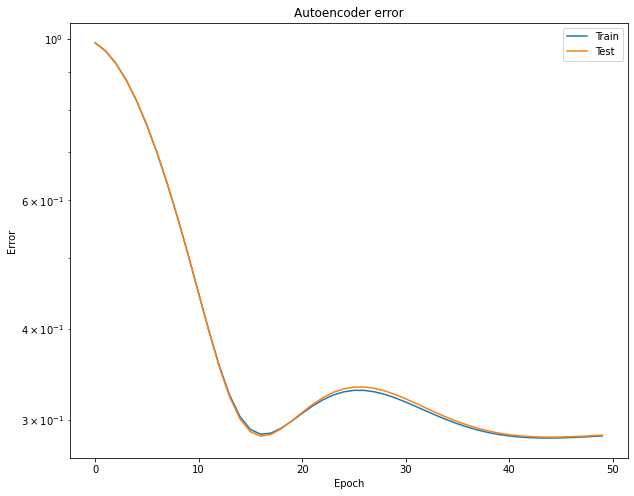

0.2855784610271281

In [64]:
Kfold_lstm(x_train, k_folds, input_size, epochs, criterion, learningRate,hidden_size_, momentum)

## Quality of the compression on the test set using the tuned parameters :

We will now train and test our auto-encoder for different sample size of our initial dataset. To do so we will do a batch processing and store the final train and test errors. See the report to see the nice comparison table :

In [6]:
import glob
import os 
import _pickle as cPickle
from sklearn.preprocessing import MinMaxScaler

dataset = 'lstm_very_small'
file_location = os.path.join('data', 'pickle', dataset, '*')
filenames = glob.glob(file_location)
i=0 


# define the parameters of the model
learningRate= 0.1
hidden_size_ = 3
momentum = 0.99

epochs=50
criterion = nn.MSELoss() 

test_errors = []
train_errors = []

for f in filenames:
    
    print("\033[1m" +'Train/Test of the sub-dataset ' + f + "\033[0m")
    
    #Load the data
    x  = cPickle.load(open(f, "rb"))
    
    #Scale between 0 and 1
    for i in range(x.shape[0]):
        scaler = MinMaxScaler()
        scaler.fit(x[i])
        x[i] = scaler.transform(x[i])
    
    #Split
    x_train, x_test = train_test_split(x, test_size=0.1, random_state=seed)
    y_train, y_test = x_train, x_test
    
    #Declare the model
    input_size=x_train.shape[2]
    model = LSTMAE(input_size, hidden_size_)
    optimizer = torch.optim.SGD(model.parameters(), lr=learningRate, momentum=momentum,weight_decay=1e-5)
    
    #Dataloader
    train_loader = DataLoader(x_train)
    test_loader = DataLoader(x_test)
    
    #Training and testing over the epochs
    for epoch in range(epochs):
        # train the model 
        train_loss=train_epoch_lstm(train_loader, model, criterion, optimizer)
        # compute the relative training error
        train_error = valid_epoch_lstm(train_loader, model)
        # compute the relative test error
        test_error=valid_epoch_lstm(test_loader, model)
        
        print("Epoch:{}/{} Training Error:{:.3f} Test Error:{:.3f}".format(epoch + 1,epochs,train_error,test_error))
    
    #Save the last epoch train and test errors
    test_errors.append(test_error)
    train_errors.append(train_error)

Train/Test of the sub-dataset data/pickle/lstm_very_small/processed_lstm_very_small_0.02_0.25
Epoch:1/50 Training Error:0.300 Test Error:0.238
Epoch:2/50 Training Error:0.283 Test Error:0.165
Epoch:3/50 Training Error:0.265 Test Error:0.171
Epoch:4/50 Training Error:0.273 Test Error:0.194
Epoch:5/50 Training Error:0.265 Test Error:0.176
Epoch:6/50 Training Error:0.270 Test Error:0.163
Epoch:7/50 Training Error:0.268 Test Error:0.163
Epoch:8/50 Training Error:0.264 Test Error:0.171
Epoch:9/50 Training Error:0.265 Test Error:0.176
Epoch:10/50 Training Error:0.264 Test Error:0.171
Epoch:11/50 Training Error:0.265 Test Error:0.165
Epoch:12/50 Training Error:0.266 Test Error:0.163
Epoch:13/50 Training Error:0.264 Test Error:0.165
Epoch:14/50 Training Error:0.263 Test Error:0.170
Epoch:15/50 Training Error:0.263 Test Error:0.171
Epoch:16/50 Training Error:0.263 Test Error:0.168
Epoch:17/50 Training Error:0.264 Test Error:0.164
Epoch:18/50 Training Error:0.265 Test Error:0.164
Epoch:19/50 Tra

Epoch:8/50 Training Error:0.305 Test Error:0.194
Epoch:9/50 Training Error:0.310 Test Error:0.191
Epoch:10/50 Training Error:0.312 Test Error:0.191
Epoch:11/50 Training Error:0.306 Test Error:0.192
Epoch:12/50 Training Error:0.304 Test Error:0.195
Epoch:13/50 Training Error:0.306 Test Error:0.193
Epoch:14/50 Training Error:0.308 Test Error:0.191
Epoch:15/50 Training Error:0.307 Test Error:0.191
Epoch:16/50 Training Error:0.307 Test Error:0.192
Epoch:17/50 Training Error:0.307 Test Error:0.192
Epoch:18/50 Training Error:0.306 Test Error:0.192
Epoch:19/50 Training Error:0.306 Test Error:0.192
Epoch:20/50 Training Error:0.306 Test Error:0.192
Epoch:21/50 Training Error:0.307 Test Error:0.191
Epoch:22/50 Training Error:0.307 Test Error:0.191
Epoch:23/50 Training Error:0.307 Test Error:0.192
Epoch:24/50 Training Error:0.306 Test Error:0.192
Epoch:25/50 Training Error:0.306 Test Error:0.192
Epoch:26/50 Training Error:0.306 Test Error:0.192
Epoch:27/50 Training Error:0.307 Test Error:0.191
Ep

Epoch:17/50 Training Error:0.264 Test Error:0.167
Epoch:18/50 Training Error:0.263 Test Error:0.169
Epoch:19/50 Training Error:0.263 Test Error:0.169
Epoch:20/50 Training Error:0.263 Test Error:0.168
Epoch:21/50 Training Error:0.264 Test Error:0.166
Epoch:22/50 Training Error:0.264 Test Error:0.165
Epoch:23/50 Training Error:0.264 Test Error:0.165
Epoch:24/50 Training Error:0.264 Test Error:0.166
Epoch:25/50 Training Error:0.263 Test Error:0.167
Epoch:26/50 Training Error:0.263 Test Error:0.167
Epoch:27/50 Training Error:0.263 Test Error:0.167
Epoch:28/50 Training Error:0.263 Test Error:0.166
Epoch:29/50 Training Error:0.264 Test Error:0.166
Epoch:30/50 Training Error:0.264 Test Error:0.166
Epoch:31/50 Training Error:0.263 Test Error:0.166
Epoch:32/50 Training Error:0.263 Test Error:0.166
Epoch:33/50 Training Error:0.263 Test Error:0.167
Epoch:34/50 Training Error:0.263 Test Error:0.166
Epoch:35/50 Training Error:0.263 Test Error:0.166
Epoch:36/50 Training Error:0.263 Test Error:0.166


In [7]:
from pandas import *
print(test_errors)
results = DataFrame({'' : ['50%', '25%', '10%'],
                   '10%' : test_errors[:3],
                   '5%' : test_errors[3:6],
                   '2%' : test_errors[6:9]})

results = results.set_index('')

display(results)
print("\033[1m" + 'Table of relative error depending on the sampling of the dataset' + "\033[0m")
print('x : sampling of times')
print('y : sampling of positions')

[0.16557153530926946, 0.1654391857956753, 0.19184089690193487, 0.1915436499705856, 0.17882232098130899, 0.17892274116897436, 0.16604665933892845, 0.19200103698791327, 0.17898203149305722]


,10%,5%,2%
,,,
50%,0.165572,0.191544,0.166047
25%,0.165439,0.178822,0.192001
10%,0.191841,0.178923,0.178982


Table of relative error depending on the sampling of the dataset
x : sampling of times
y : sampling of positions


In [8]:
#Save in pickles

name = "lstm_train_errors_" + dataset
cPickle.dump( train_errors , open( name, "wb" ) )
name = "lstm_test_errors_" + dataset
cPickle.dump( test_errors , open( name, "wb" ) )

## 5. Discussion & conclusion <a name="ccl"></a>